This Notebook enables more visualization of the 3 trees (E13, E16, G3) after recomputation of the missing radiuses and leaf numbers. The model "visual model" was created only to see quickly the 3D representations of these trees, without calculations in the background.

In [1]:
import numpy as np
import pandas as pd
import igraph as ig
from importlib import resources
import vmlab

reloaded


In [2]:
from scipy.sparse import csgraph
import matplotlib.pyplot as plt

In [3]:
from vmlab.models import visual_model

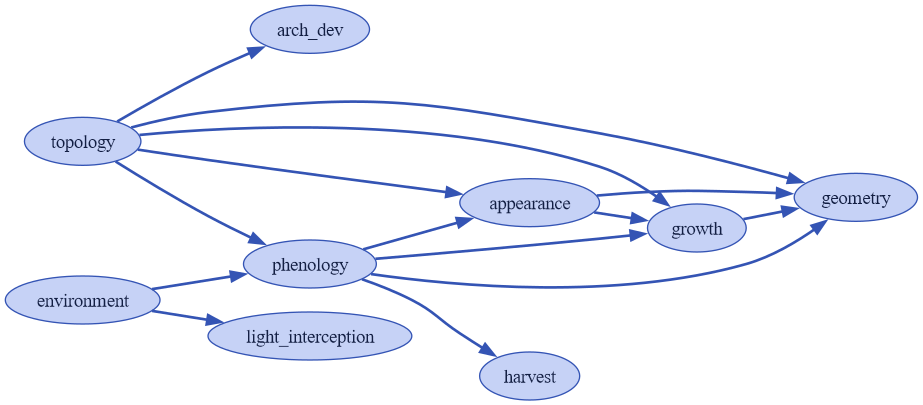

In [4]:
visual_model.visualize()

The orange GUs bear at least one fruit, and the green ones at leats one leaf. The purple GUs are "branches", the pink ones are "branches empty" , the grey ones are "undefined"or "multiple GUs".

# TREE E13

## Tree visualisation

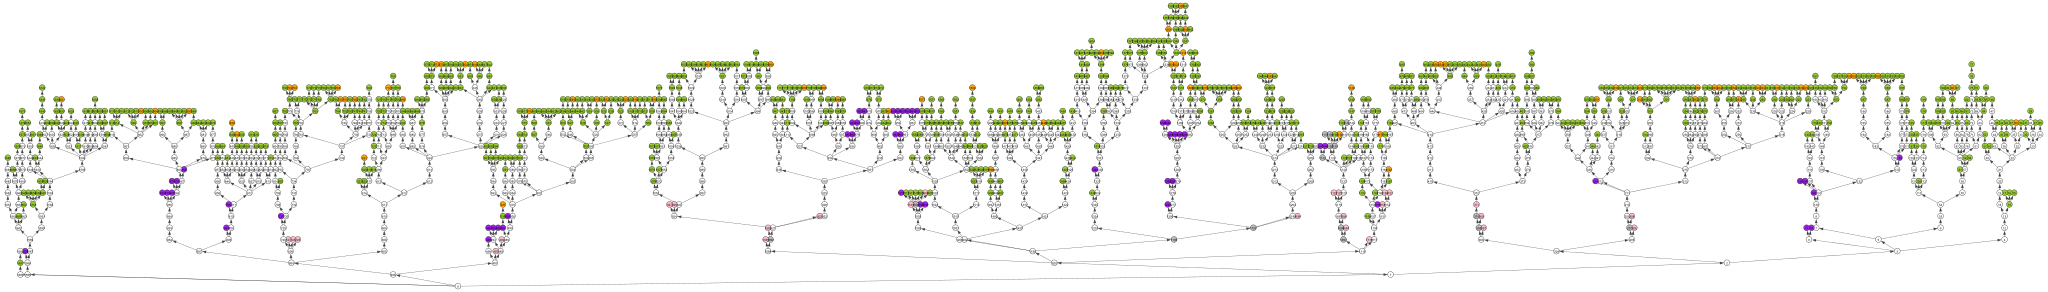

In [5]:
with resources.path('vmlab.data.trees', 'tree_E13_leaf_completed.csv') as path:
    tree = pd.read_csv(path)
    graph = vmlab.to_graph(tree)
vmlab.plot_graph(graph, 7000,1000)

In [6]:
setup = vmlab.create_setup(
    model=visual_model,
    tree=tree,
    start_date='2002-06-01',
    end_date='2002-06-02',
    setup_toml='visual_model.toml',
    current_cycle=3,
    input_vars={
        'growth__leaf_senescence_enabled': False,
        'geometry__interpretation_freq': 1
    },
    output_vars={
    }
)

In [7]:
#ds_out = vmlab.run(setup, visual_model, geometry=True)

# TREE G3

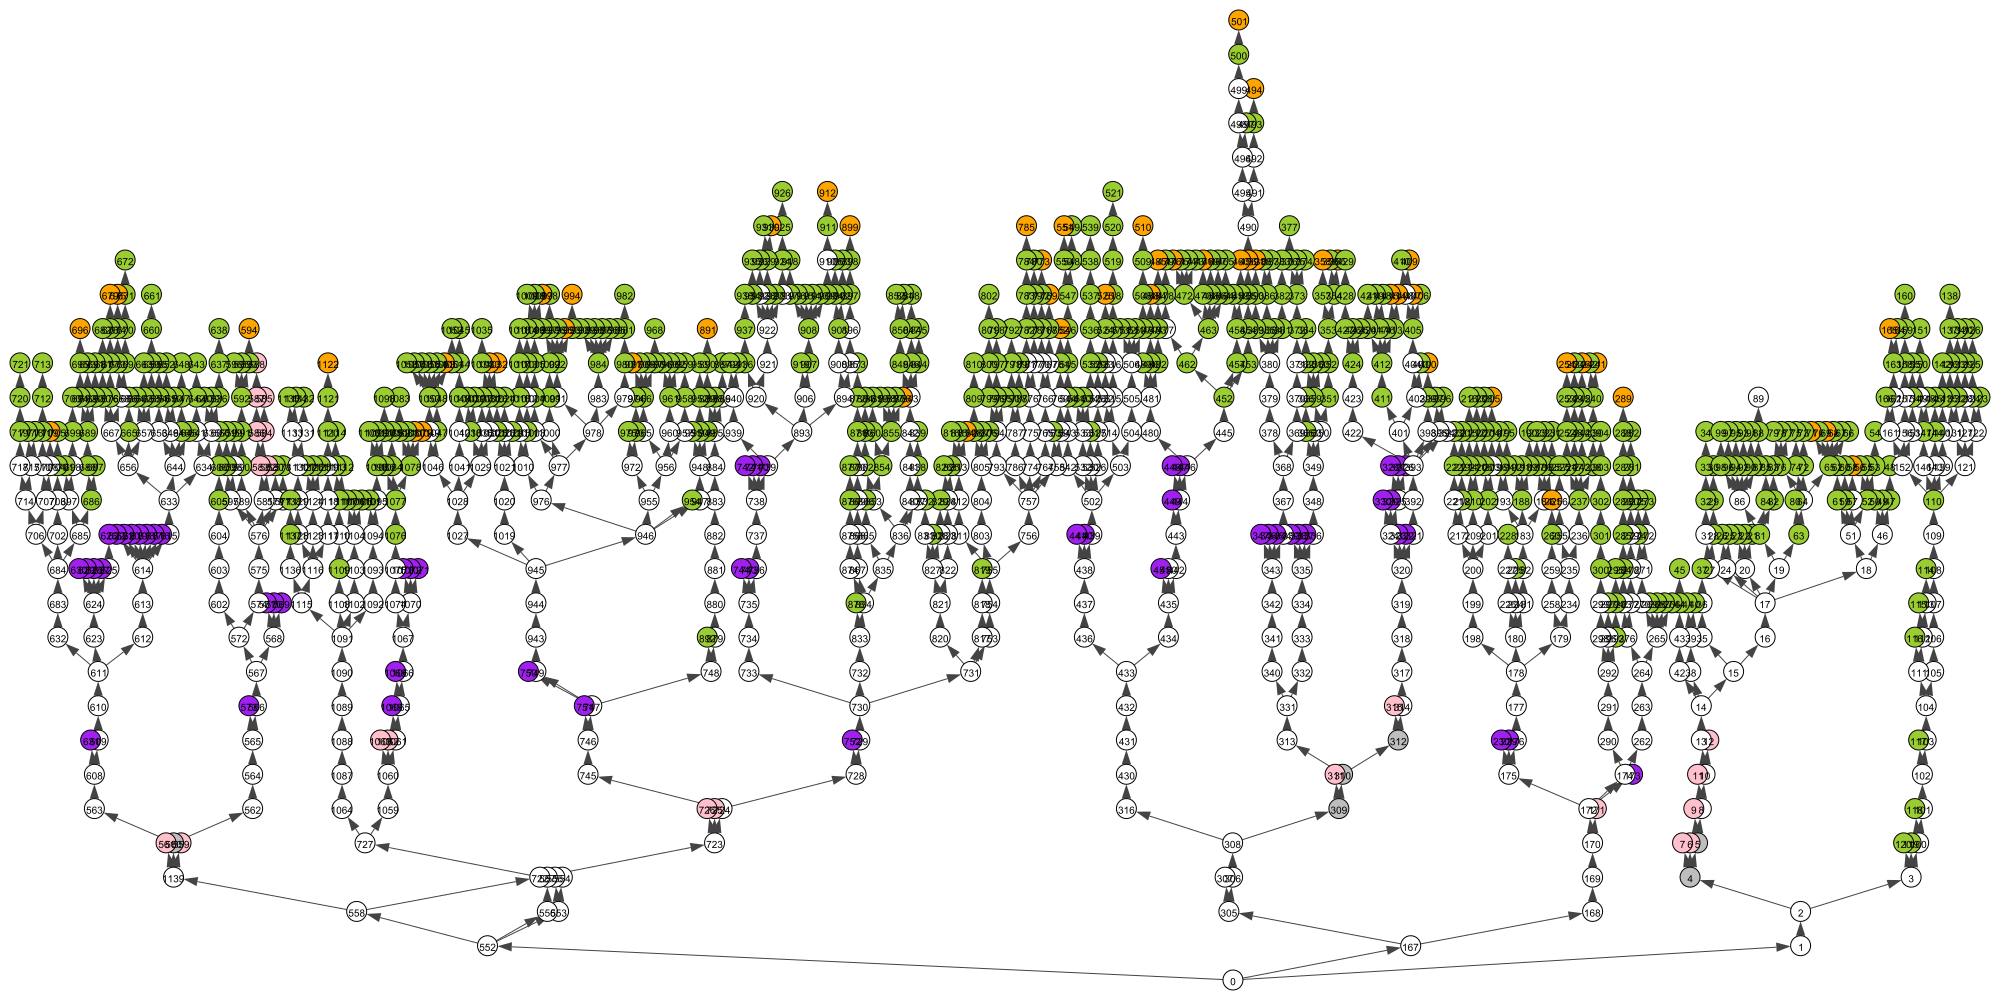

In [8]:
with resources.path('vmlab.data.trees', 'tree_G3_leaf_completed.csv') as path:
    tree = pd.read_csv(path)
    graph = vmlab.to_graph(tree)
vmlab.plot_graph(graph, 2000,1000)

In [9]:
setup = vmlab.create_setup(
    model=visual_model,
    tree=tree,
    start_date='2002-06-01',
    end_date='2002-06-02',
    setup_toml='visual_model.toml',
    current_cycle=3,
    input_vars={
        'growth__leaf_senescence_enabled': False,
        'geometry__interpretation_freq': 1
    },
    output_vars={
    }
)

In [10]:
#ds_out = vmlab.run(setup, visual_model, geometry=True)

# TREE E16

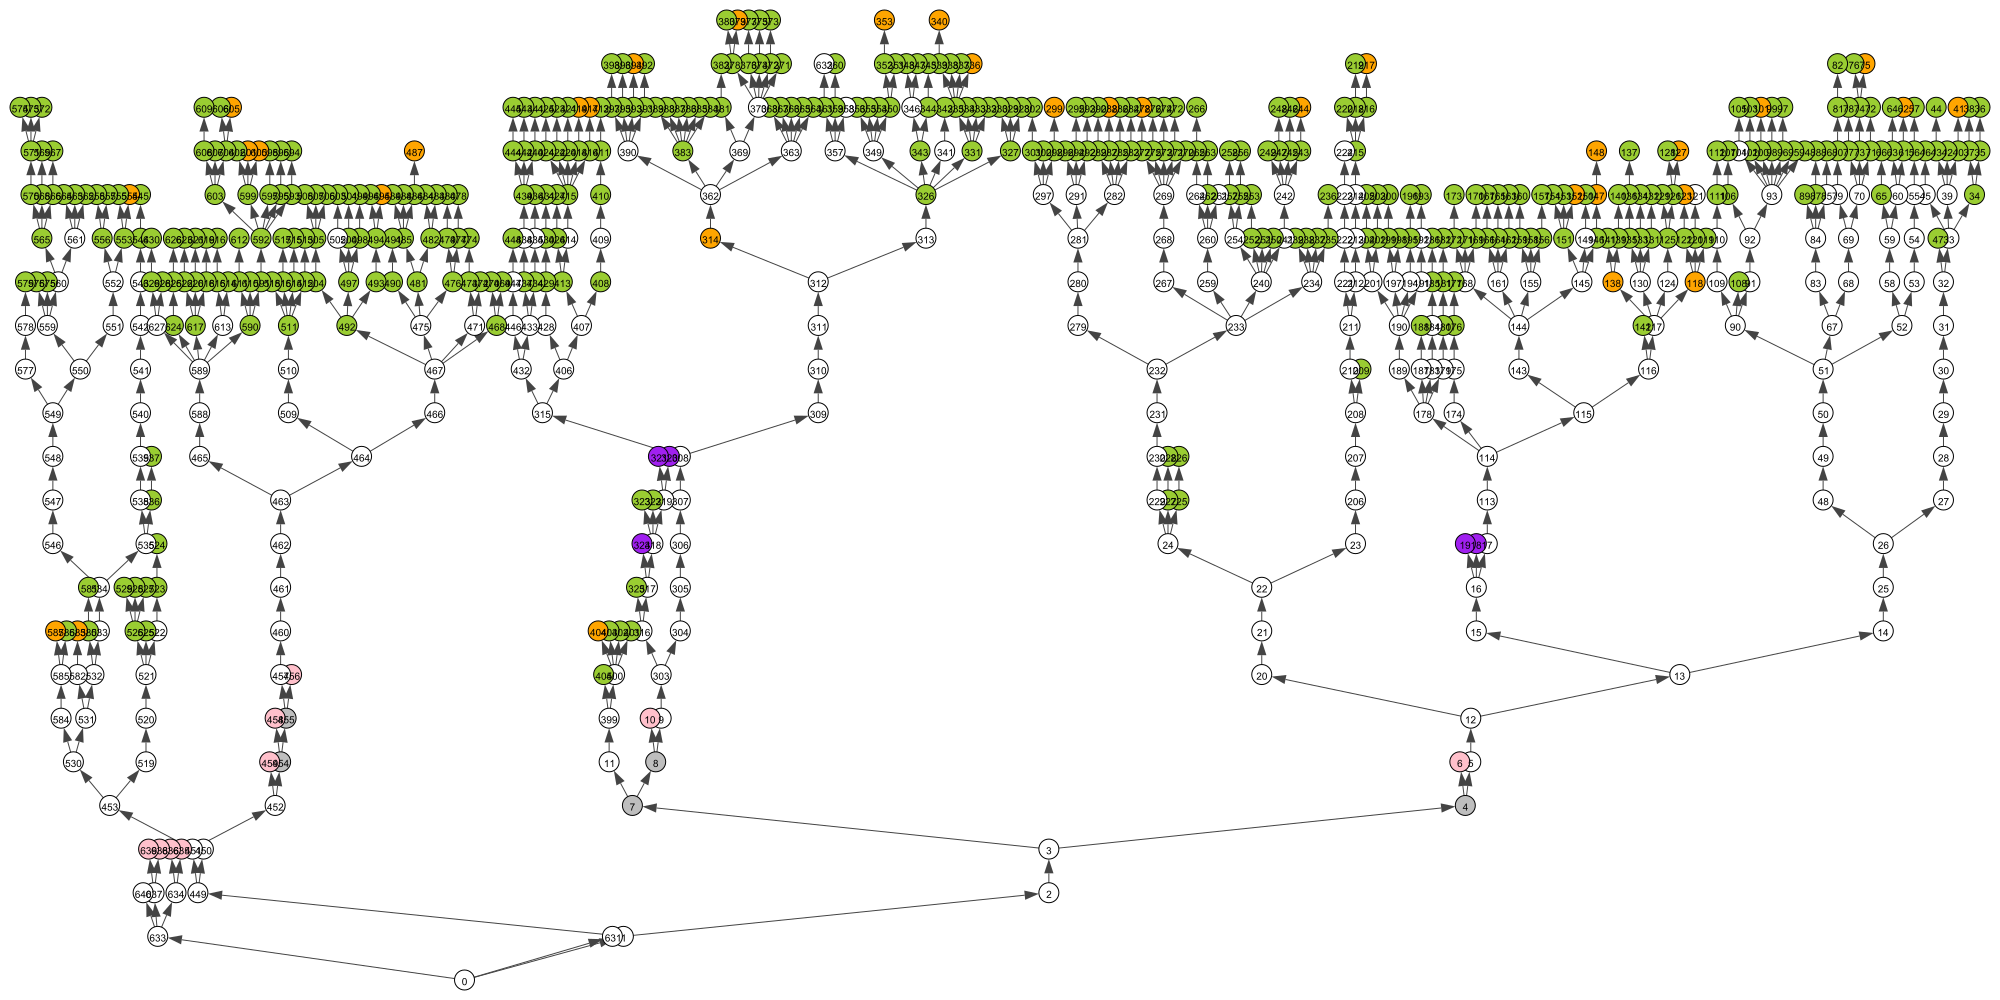

In [11]:
with resources.path('vmlab.data.trees', 'tree_E16_leaf_completed.csv') as path:
    tree = pd.read_csv(path)
    graph = vmlab.to_graph(tree)
vmlab.plot_graph(graph, 2000,1000)

In [12]:
setup = vmlab.create_setup(
    model=visual_model,
    tree=tree,
    start_date='2002-06-01',
    end_date='2002-06-02',
    setup_toml='visual_model.toml',
    current_cycle=3,
    input_vars={
        'growth__leaf_senescence_enabled': False,
        'geometry__interpretation_freq': 1
    },
    output_vars={
    }
)

In [13]:
#ds_out = vmlab.run(setup, visual_model, geometry=True)

# BONUS : Branches visualisation for the "tree_exploration_topo" notebook

Ploting graph where the GUs counted in "is_in_distance_to_fruit" appear blue.

In [20]:
dmax = 10
with_successors=True
aggregate = True

In [21]:
graph = vmlab.to_graph(tree)
adjacency = np.array(graph.get_adjacency())
GUs = tree.loc[tree.loc[:,'type'] == 'GU']
# GUs = tree.drop(labels = [i for i in tree.loc[:,'id'] if tree.loc[i,'type']!='GU']) # list of all the GU without "branch", "branch_empty"... for when necessary

# Initializaton (setting dtypes)
distance_to_fruit_GU = np.array([], dtype=np.float32)
distance_to_fruit = np.array([], dtype=np.float32)
is_in_distance_to_fruit = np.array([], dtype=bool)
is_in_distance_to_fruit_GU = np.array([], dtype=bool)

is_fruting = tree['arch_dev__pot_nb_fruit'] > 0
is_fruting_and_GU_type = GUs['arch_dev__pot_nb_fruit'] > 0

# Collecting GUs at the chosen distance (with or without successors) from each fruit of the tree :

if np.any(is_fruting_and_GU_type) : 
    distance_to_fruit = csgraph.shortest_path( 
                                adjacency,
                                indices=np.array(GUs[is_fruting_and_GU_type].index),
                                directed=False
                                ).astype(np.float32)
# if np.any(is_fruting) : 
#     distance_to_fruit = csgraph.shortest_path( 
#                                 adjacency,
#                                 indices=np.flatnonzero(is_fruting),
#                                 directed=False
#                                 ).astype(np.float32)

    # including successors :     
    if with_successors :
        distance_to_fruit[distance_to_fruit > dmax] = np.inf 
        is_in_distance_to_fruit = np.isfinite(distance_to_fruit).astype(np.float32)
        

        for fruit in is_in_distance_to_fruit :
            is_a_potential_mother = np.flatnonzero(fruit)
            distance_to_mother = csgraph.shortest_path( 
                                    adjacency,
                                    indices=is_a_potential_mother,
                                    directed=True
                                ).astype(np.float32)    
            belongs_to_mother = np.isfinite(distance_to_mother).astype(np.float32)
            fruit += np.nansum(belongs_to_mother, axis=0)
            
        is_in_distance_to_fruit[is_in_distance_to_fruit!= 0] = 1

    # not including successors :
    else :
        if aggregate :
            distance_to_fruit[distance_to_fruit > dmax] = np.inf # collecting GU at exactly a dmax distance
        else : 
            distance_to_fruit[distance_to_fruit != dmax] = np.inf # collecting GU under a dmax distance
        
        is_in_distance_to_fruit = np.isfinite(distance_to_fruit).astype(np.float32)

        
# Collecting fruity and leafy GUs among the previously selected GUs :
reachable_leaves = np.copy(is_in_distance_to_fruit)
reachable_fruits = np.copy(is_in_distance_to_fruit)
lit_frac = np.copy(is_in_distance_to_fruit)
# Taking into account the fact that some leaves share their carbon production between several fruits :

if with_successors :
    leaf_fruit_sharing_number = np.nansum(np.transpose( 
    np.multiply(
        np.transpose(is_in_distance_to_fruit),                                                # GU bearing fruits to take into account
        np.array(GUs.loc[np.array(GUs[is_fruting_and_GU_type].index), 'arch_dev__pot_nb_fruit']) # number of fruits on these GUs                                                 
        )),
    axis=0)
    
else :    
    leaf_fruit_sharing_number = np.nansum(np.transpose( 
    np.multiply(
        np.transpose(is_in_distance_to_fruit),                                                # GU bearing fruits to take into account
        np.array(GUs.loc[np.array(GUs[is_fruting_and_GU_type].index), 'arch_dev__pot_nb_fruit']) # number of fruits on these GUs                                                 
        )),
    axis=0)

leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number 
leaf_fruit_sharing_fraction[leaf_fruit_sharing_fraction==np.inf] = 0 

In [18]:
color = pd.DataFrame(is_in_distance_to_fruit, index = np.array(GUs[is_fruting_and_GU_type].index))
chosen_fruit = 288 #among color.index

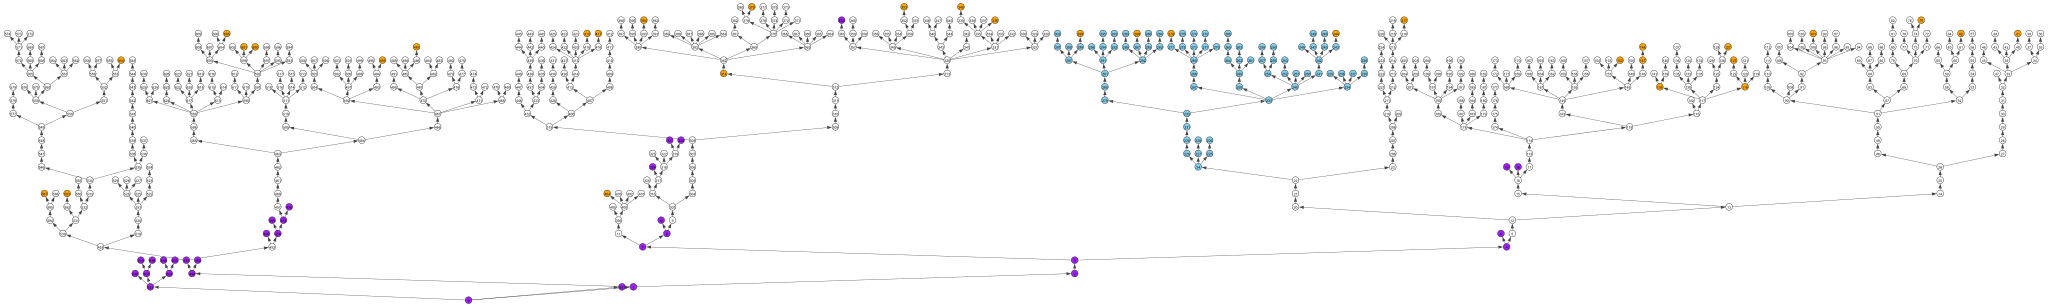

In [25]:
layout = graph.layout_reingold_tilford()
layout.rotate(180)
ig.plot(
    graph, 
    bbox=(0,0,6000,900), 
    layout=layout, 
    vertex_label=graph.vs.get_attribute_values('id'),
    vertex_label_size=10,
    vertex_color=['purple' if GU_type!='GU' else 'orange' if fruit>0 else 'skyblue' if color.loc[chosen_fruit,gu]!=0  else 'white' for GU_type,fruit,gu in zip(
        graph.vs.get_attribute_values('type'),
        graph.vs.get_attribute_values('arch_dev__pot_nb_fruit'),
        graph.vs.get_attribute_values('id'))
    ])

In [23]:
liste = np.array(color.loc[353, color.loc[353]==1].index)
tree.loc[liste]

id            type  parent_id  scaffold_id  topology__is_apical  \
308  308              GU      307.0          2.0                  1.0   
309  309              GU      308.0          2.0                  1.0   
310  310              GU      309.0          2.0                  1.0   
311  311              GU      310.0          2.0                  1.0   
312  312              GU      311.0          2.0                  1.0   
..   ...             ...        ...          ...                  ...   
445  445              GU      444.0          2.0                  1.0   
446  446              GU      432.0          2.0                  0.0   
447  447              GU      446.0          2.0                  0.0   
448  448              GU      447.0          2.0                  1.0   
632  632  scaffold_empty      361.0        631.0                  1.0   

    arch_dev__pot_flowering_date  arch_dev__pot_nb_inflo  \
308                          NAT                     NaN   
309                          NAT                     NaN   
310                          NAT                     NaN   
311                          NAT                     NaN   
312                          NAT                     NaN   
..                           ...                     ...   
445                          NAT                     NaN   
446                          NAT                     NaN   
447                          NAT                     NaN   
448                          NAT                     NaN   
632                          NAT                     NaN   

     arch_dev__pot_nb_fruit  growth__nb_leaf  growth__radius_gu  \
308                     NaN                0           2.146473   
309                     NaN                0           2.101289   
310                     NaN                0           2.021594   
311                     NaN                0           1.944420   
312                     NaN                0           1.869668   
..                      ...              ...                ...   
445                     NaN                7           0.194000   
446                     NaN                0           0.303949   
447                     NaN                0           0.244686   
448                     NaN                2           0.172000   
632                     NaN                0           2.540000   

     appearance__final_length_gu environment_id  \
308                         12.0            NaN   
309                         13.0            NaN   
310                         11.0            NaN   
311                         13.0            NaN   
312                         13.0            NaN   
..                           ...            ...   
445                          6.0        E16_11D   
446                          5.0            NaN   
447                          3.0            NaN   
448                          5.0        E16_11E   
632                        101.0            NaN   

     light_interception__sunlit_fraction_col  
308                                      3.0  
309                                      3.0  
310                                      3.0  
311                                      3.0  
312                                      3.0  
..                                       ...  
445                                      3.0  
446                                      3.0  
447                                      3.0  
448                                      3.0  
632                                      3.0  

[125 rows x 13 columns]